In [284]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import time
from typing import Callable, Union

## 3
(by hand) Verify that the minimizer satisfies the sufficient optimality conditions. (Hint: you can compute eigenvalues of a matrix in Matlab using the command eig).

In [285]:
f = lambda x, y: 100*(y - x**2)**2 + (1 - x)**2
df = lambda x, y: np.array([-400*x*(y - x**2) + 2 * x - 2, 200*(y - x ** 2)])
ddf = lambda x, y: np.array([[1200*x**2 - 400*y + 2, -400*x], [-400*x, 200]])

The sufficient optimality conditions for a minimizer are
$$\nabla f(\bold x^*) = 0$$
$$\nabla^2 f(\bold x^*) \succ 0$$
with $\bold x^* = (1, 1)^T$.

In [286]:
print("The gradient to the minimizer is ", df(1,1))
print("The hessian to the minimizer is \n", ddf(1,1))

The gradient to the minimizer is  [0 0]
The hessian to the minimizer is 
 [[ 802 -400]
 [-400  200]]


In [287]:
eigs = np.linalg.eig(ddf(1,1))
print("The eigenvalues of the hessian are ", eigs[0])
print("The eigenvectors of the hessian are \n", eigs[1])

The eigenvalues of the hessian are  [1.00160064e+03 3.99360767e-01]
The eigenvectors of the hessian are 
 [[ 0.89478425  0.44649877]
 [-0.44649877  0.89478425]]


And we can see that the hessian has only positive eigenvalues and is therefore positive definite, meaning that the sufficient optimality conditions are satisfied.

## 4 - 6

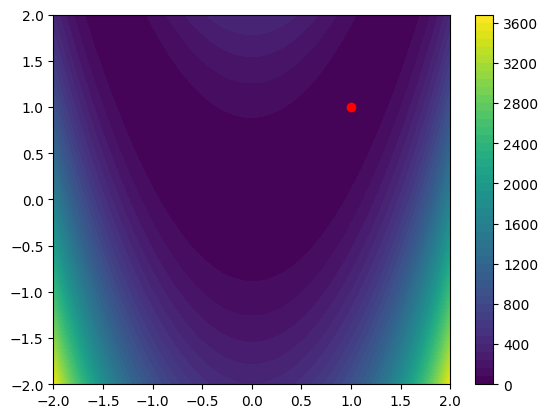

In [288]:
def create_contour_sympy(expression, symbs, xlim, ylim, lvls, axs=None):
    # Sympy expression needed
    # With symbols of the expression
    func = sp.lambdify(symbs, expression, modules=['numpy'])
    x1_vals = np.linspace(xlim[0], xlim[1], 500)
    x2_vals = np.linspace(ylim[0], ylim[1], 500)
    X, Y = np.meshgrid(x1_vals, x2_vals)
    Z = func(X, Y)
    if len(Z.shape) == 4:
        Z = Z[0,0]
    return plt.contourf(X, Y, Z, levels=lvls) if axs is None else axs.contourf(X, Y, Z, levels=lvls)  
# You can adjust the number of contour levels

x,y = sp.symbols("x y")
expr = 100*(y - x**2)**2 + (1 - x)**2

cont = create_contour_sympy(expr, (x,y), (-2,2), (-2,2), 50)
plt.plot(1,1, 'ro')
plt.colorbar(cont)

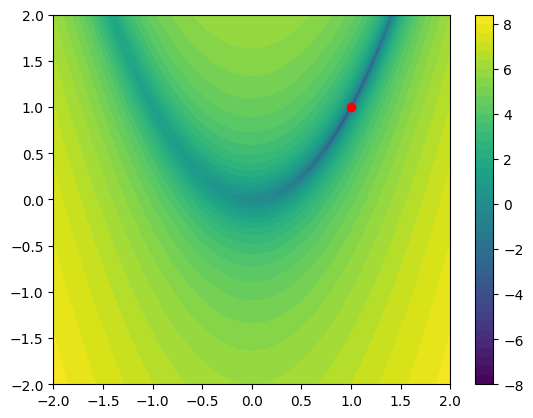

In [289]:
cont = create_contour_sympy(sp.log(expr), (x,y), (-2,2), (-2,2), 50)
plt.plot(1,1, 'ro')
plt.colorbar(cont)

The two plots convey the same information, however, the scale makes it quite hard to see. The log plot conveys the information better, as we are working with very small values otherwise.

## 7

In [335]:
def steepest_descent(f, fd, x0, tol, max_iter,alpha=1, backtrack = True):
    start = time.time()
    xstar = np.array([1,1])
    c = 0.8
    rho = 0.1
    converge = False

    x = np.array(x0)

    stats = {'k': [0], 'fxk': [f(*x)], 'ek': [np.linalg.norm(xstar - x)], 'alphak': [alpha],
              'xk': [x], 'x_star': 0, 'it_time': [], 'time': 0}

    for i in range(max_iter):
        start_iter = time.time()
        pk = -fd(*x)/np.linalg.norm(fd(*x))

        if backtrack:
            alpha = 1
            left = f(*(x + alpha * pk))
            right = f(*x) + c*alpha*fd(*x).T@pk
            # Backtracking - evaluate function at each half-decreasing alpha
            while left > right: #and df(*(x + alpha* pk)).T@pk >= 0.9*fd(*x).T@pk:
                alpha = alpha*rho
                left = f(*(x + alpha * pk))
                right = f(*x) + c*alpha*fd(*x).T@pk
                
        x = x + alpha*pk
        stats['k'].append(i+1)
        stats['fxk'].append(f(*x))
        stats['ek'].append(np.linalg.norm(xstar - x))
        stats['alphak'].append(alpha)
        stats['xk'].append(x)
        end_iter = time.time()
        stats['it_time'].append(end_iter - start_iter)
        if np.linalg.norm(fd(*x), np.inf) < tol:
            stats["x_star"] = x
            converge = True
            print("Converged!")
            break

    if not converge:
        print("Didn't converge!")
        stats["x_star"] = stats["xk"][-1]
    end = time.time()
    stats["time"] = end - start
    stats["it_time"] = np.mean(stats["it_time"])
    return stats

Didn't converge!


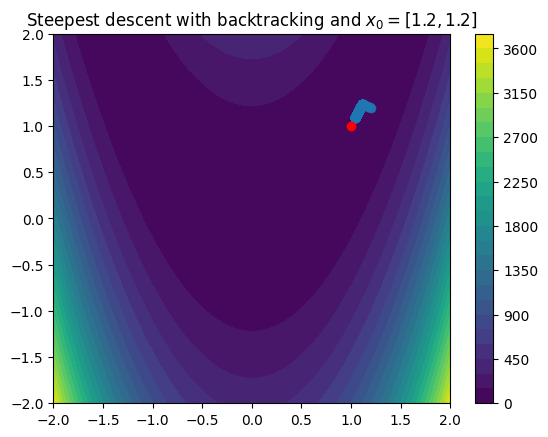

Text(0.5, 1.0, 'Step size')

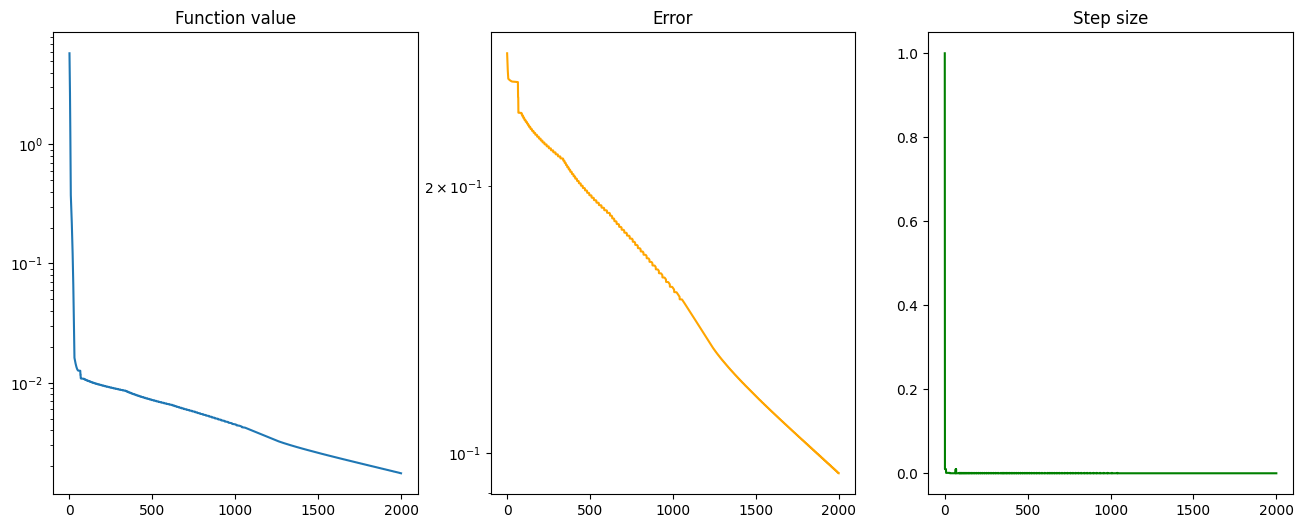

In [291]:
alpha, backtrack, x0 = 1, True, [1.2,1.2]

SD_stats = steepest_descent(f, df, [1.2,1.2], 1e-8, 2000, alpha=alpha, backtrack = backtrack)
cont = create_contour_sympy(expr, (x,y), (-2,2), (-2,2), 25)

plt.colorbar(cont)
plt.title("Steepest descent $\\alpha = {}$ and $x_0 = {}$".format(alpha, x0)) if not backtrack else plt.title("Steepest descent with backtracking and $x_0 = {}$".format(x0))
plt.plot([x[0] for x in SD_stats["xk"]], [x[1] for x in SD_stats["xk"]], 'o-', alpha=0.8)
plt.plot(1,1, 'ro')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
ax1.semilogy(SD_stats["k"], SD_stats["fxk"])
#ax1.legend(["$f(x_k)$"])
ax1.set_title("Function value")

ax2.semilogy(SD_stats["k"], SD_stats["ek"], c="orange")
#ax2.legend(["$e_k$"])
ax2.set_title("Error")

ax3.plot(SD_stats["k"], SD_stats["alphak"], c="green")
#ax3.legend(["$\\alpha_k$"])
ax3.set_title("Step size")

In [292]:
alphas = [0.0001, 0.001, 0.005, 0.01]

SD_statses = [steepest_descent(f, df, x0, 1e-8, 2000, alpha=alpha, backtrack = False) for alpha in alphas]
SD_statses2 = [steepest_descent(f, df, [-1.2,1], 1e-8, 2000, alpha=alpha, backtrack = False) for alpha in alphas]
SD_statses3 = steepest_descent(f, df, x0, 1e-8, 2000, alpha=alpha, backtrack = True)
SD_statses4 = steepest_descent(f, df, [-1.2,1], 1e-8, 2000, alpha=alpha, backtrack = True)

Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!
Didn't converge!


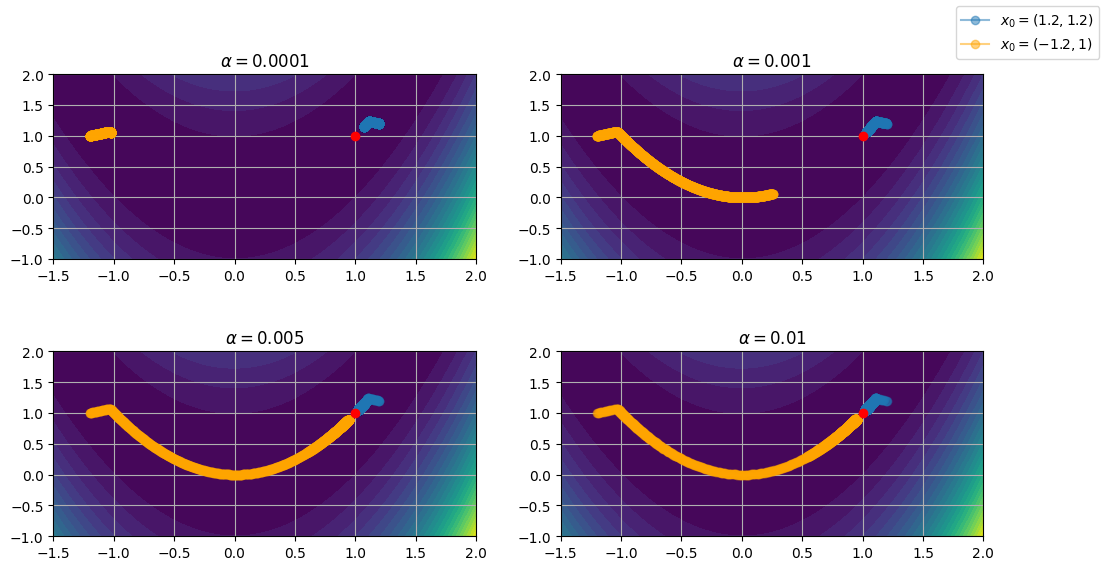

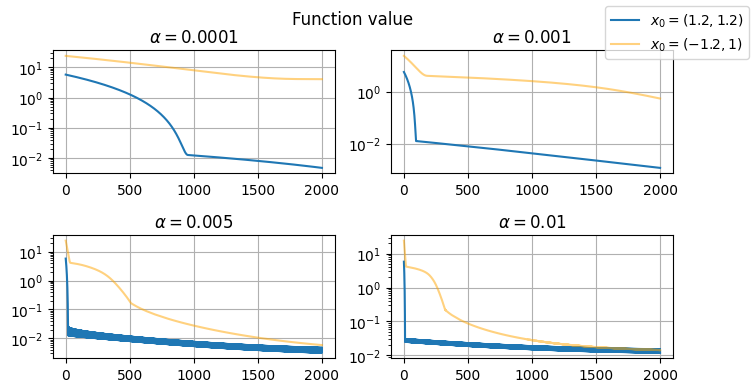

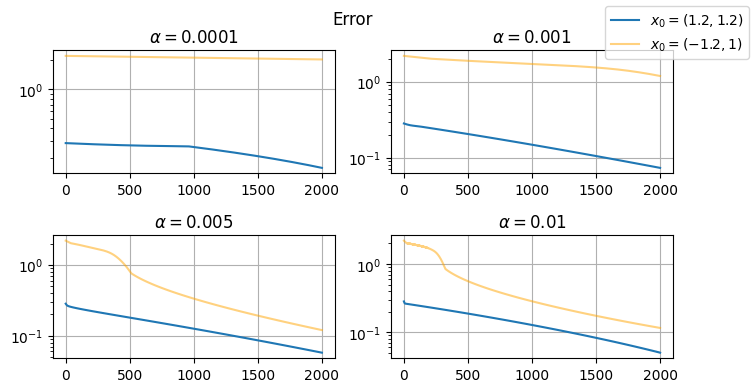

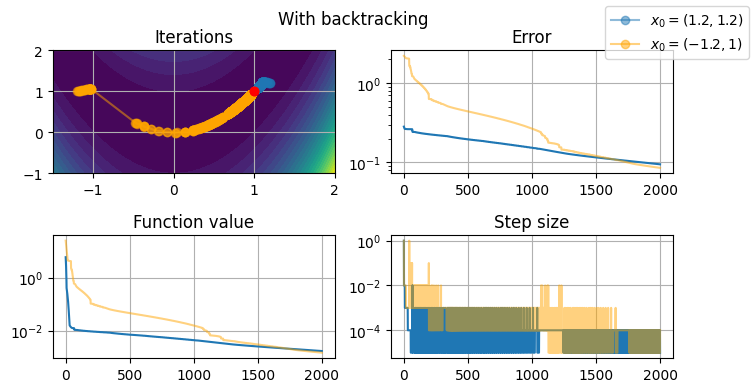

In [293]:

fig, axs = plt.subplots(2, 2, figsize=(12,6))
for i, ax in enumerate(axs.flatten()):
    create_contour_sympy(expr, (x,y), (-1.5,2), (-1,2), 25, axs=ax)
    ax.plot([x[0] for x in SD_statses[i]["xk"]], [x[1] for x in SD_statses[i]["xk"]], 'o-', alpha=0.5)
    ax.plot([x[0] for x in SD_statses2[i]["xk"]], [x[1] for x in SD_statses2[i]["xk"]], 'o-', alpha=0.5, c="orange")
    ax.plot(1,1, 'ro')
    ax.set_title("$\\alpha = {}$".format(alphas[i]))
    ax.set_xlim(-1.5,2)
    ax.set_ylim(-1,2)
    ax.grid()
fig.legend(["$x_0 = (1.2,1.2)$", "$x_0 = (-1.2,1)$"], loc="upper right")
fig.subplots_adjust(hspace = 0.5)

fig, axs = plt.subplots(2, 2, figsize=(8,4))
for i, ax in enumerate(axs.flatten()):
    ax.semilogy(SD_statses[i]["k"], SD_statses[i]["fxk"])
    ax.semilogy(SD_statses2[i]["k"], SD_statses2[i]["fxk"], c="orange", alpha=0.5)
    ax.set_title("$\\alpha = {}$".format(alphas[i]))
    ax.grid()
fig.legend(["$x_0 = (1.2,1.2)$", "$x_0 = (-1.2,1)$"], loc="upper right", ncol=1)
fig.subplots_adjust(hspace = 0.5)
fig.suptitle("Function value")


fig, axs = plt.subplots(2, 2, figsize=(8,4))
for i, ax in enumerate(axs.flatten()):
    ax.semilogy(SD_statses[i]["k"], SD_statses[i]["ek"])
    ax.semilogy(SD_statses2[i]["k"], SD_statses2[i]["ek"], c="orange", alpha=0.5)
    ax.set_title("$\\alpha = {}$".format(alphas[i]))
    ax.grid()
fig.legend(["$x_0 = (1.2,1.2)$", "$x_0 = (-1.2,1)$"], loc="upper right", ncol=1)
fig.subplots_adjust(hspace = 0.5)
fig.suptitle("Error")

fig, axs = plt.subplots(2, 2, figsize=(8,4))
create_contour_sympy(expr, (x,y), (-1.5,2), (-1,2), 25, axs=axs[0,0])
axs[0,0].plot([x[0] for x in SD_statses3["xk"]], [x[1] for x in SD_statses3["xk"]], 'o-', alpha=0.5)
axs[0,0].plot([x[0] for x in SD_statses4["xk"]], [x[1] for x in SD_statses4["xk"]], 'o-', alpha=0.5, c="orange")
axs[0,0].plot(1,1, 'ro')

axs[0,0].plot(1,1, 'ro')
axs[0,0].set_title("Iterations")
axs[0,0].grid()


axs[1,0].semilogy(SD_statses3["k"], SD_statses3["fxk"])
axs[1,0].semilogy(SD_statses4["k"], SD_statses4["fxk"], c="orange", alpha=0.5)
axs[1,0].set_title("Function value")
axs[1,0].grid()

axs[0,1].semilogy(SD_statses3["k"], SD_statses3["ek"])
axs[0,1].semilogy(SD_statses4["k"], SD_statses4["ek"], c="orange", alpha=0.5)
axs[0,1].set_title("Error")
axs[0,1].grid()

axs[1,1].semilogy(SD_statses3["k"], SD_statses3["alphak"])
axs[1,1].semilogy(SD_statses4["k"], SD_statses4["alphak"], c="orange", alpha=0.5)
axs[1,1].set_title("Step size")
axs[1,1].grid()


fig.subplots_adjust(hspace = 0.5)
fig.suptitle("With backtracking")
fig.legend(["$x_0 = (1.2,1.2)$", "$x_0 = (-1.2,1)$"], loc="upper right", ncol=1)




In [294]:
print("SD took ", SD_stats["time"], " seconds to run")

SD took  0.18903350830078125  seconds to run


In [295]:
def rosenbrock(X, return_derivatives: bool = True):
    x1, x2 = X
    f = 100 * (x2 - x1**2)**2 + (1 - x1)**2

    if return_derivatives:
        df = np.array([-400*x1*(x2 - x1**2) + 2 * x1 - 2, 200*(x2 - x1 ** 2)])
        ddf = np.array([[1200*x1 ** 2 - 400*x2+2, -400*x1],[-400*x1,200]])
        return f, df, ddf
    return f

rosenbrock_lambda = lambda x: 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
rosenbrock_grad_lambda = lambda x: np.array([-400*x[0]*(x[1] - x[0]**2) + 2 * x[0] - 2, 200*(x[1] - x[0] ** 2)])

def BFGS_line(x0: np.array, func: Callable, grad_f: Callable, iterations: int, **kwargs):
    """
    function must return (function value, gradient, hessian)
    """
    H = np.eye(len(x0))
    I = np.eye(len(x0))
    
    grad = grad_f(x0)
    
    x = x0
    
    xs = [x]
    ys = [func(x)]
    
    errors = [np.linalg.norm(x-kwargs["x_star"])]
    
    
    for k in range(iterations):
        grad = grad_f(x)
        
        
        p = -H @ grad
        
        
        alpha = backtrack(x, func, grad, p)
        
        next_x = x + alpha * p
        s = next_x - x
        y = grad_f(next_x) - grad
        
        if np.linalg.norm(grad, np.inf) <= kwargs["tol"]:
            break

        rho = 1 / np.dot(y, s)
        
        A = I - rho * np.outer(s, y)
        B = I - rho * np.outer(y, s)
        
        H = A @ H @ B + rho * np.outer(s, s)
        
        x = next_x
        
        xs.append(x)
        ys.append(func(x))
        errors.append(np.linalg.norm(x-kwargs["x_star"]))
    
    return xs, ys, errors
        
def backtrack(x, f, df, direction):
    alpha = 0.1
    c = 0.5
    rho = 0.8
    while f(x + alpha*direction) > (f(x) + c * alpha * df @ direction):
        alpha *= rho
    return alpha

x0 = np.array([1.2,1.2])
xbfg, ybfg, e = BFGS_line(x0, func=rosenbrock_lambda, grad_f=rosenbrock_grad_lambda, iterations=2000, x_star=np.array([1,1]), tol=1e-10)

In [296]:
def newtons_method(f: sp.Expr, vars: list[sp.Symbol], x0: np.ndarray, alpha: float=1, max_iter: int = 2000, tol: float=1e-10):
    if x0.ndim == 2:
        x0 = x0.squeeze()
    df = sp.Matrix([sp.diff(f, v) for v in vars])
    d2f = sp.Matrix([[sp.diff(expr, v) for v in vars] for expr in df])

    f = sp.lambdify(vars, f)
    df = sp.lambdify(vars, df)
    d2f = sp.lambdify(vars, d2f)

    xs = [x0]
    fs = [f(*x0)]

    x = x0
    
    k = 0
    while (k < max_iter) and (np.linalg.norm(df(*x), np.inf) >= tol):
        x = x.copy()
        p = -np.linalg.pinv(d2f(*x)) @ df(*x)
        p = p.squeeze()
        # print(f"x: {x}")
        # print(f"p: {p}")
        
        x += alpha*p
        # print(f"new x: {x}")

        xs.append(x)
        fs.append(f(*x))

        k += 1
        # print(np.linalg.norm(x, np.inf))
        # if k > 5:
        #     break

    return xs, fs, k

def get_errors(xs, x_star):
    return [np.linalg.norm(v - x_star, 2) for v in xs]


q, p = sp.symbols("q p")
f_newt = 100*(p - q**2)**2 + (1 - p)**2
x_star = np.array([[1],[1]])
xs, fs, k = newtons_method(f_newt, [q, p], np.array([1.2,1.2]))
errors = get_errors(xs, x_star)



In [297]:
1e-10

1e-10

In [336]:
SD_statses5 = steepest_descent(f, df, [1.2,1.2], 10e-10, 2000, alpha=alpha, backtrack = True)

Didn't converge!


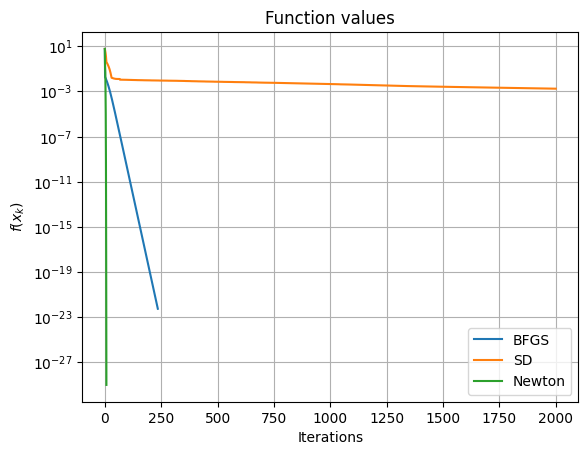

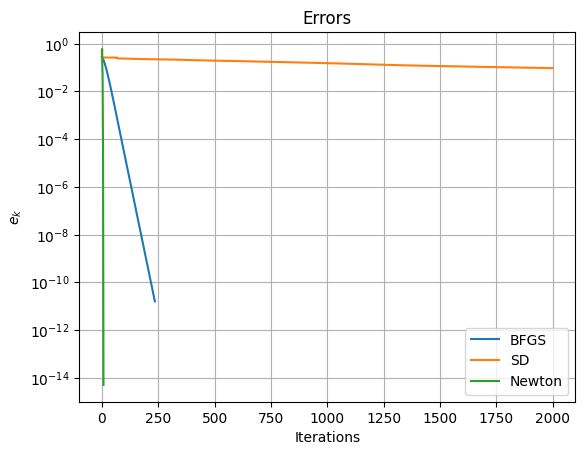

In [337]:
plt.semilogy(range(len(xbfg)), ybfg)
plt.semilogy(SD_statses5["k"], SD_statses5["fxk"])
plt.semilogy(np.linspace(0,k,k+1), fs)
plt.legend(["BFGS", "SD", "Newton"])
plt.title("Function values")
plt.xlabel("Iterations")
plt.ylabel("$f(x_k)$")
plt.grid()
plt.show()

plt.semilogy(range(len(xbfg)), e)
plt.semilogy(SD_statses5["k"], SD_statses5["ek"])
plt.semilogy(np.linspace(0,k,k+1), errors)
plt.legend(["BFGS", "SD", "Newton"])
plt.title("Errors")
plt.xlabel("Iterations")
plt.ylabel("$e_k$")
plt.grid()
plt.show()

#plt.plot(range(len(x)), e)
#plt.show()

In [300]:
SD_statses5["k"][-1]

2000

In [301]:
er =  np.array(SD_statses5["ek"])

In [302]:
#The last 200 entries of
(np.log(er[2:] / er[1:-1]) / np.log(er[1:-1] / er[:-2]))[-100:]

array([10.45165441,  0.09003358,  1.06540561, 10.43827797,  0.09193172,
        1.05930497, 10.3881518 ,  0.09103569,  1.05848741, 10.38033452,
        0.09276793, 10.53449747,  0.08870817,  1.07441578, 10.51696301,
        0.09073704,  1.06787962, 10.46026468,  0.08972685,  1.06710529,
       10.4507558 ,  0.09157967,  1.06137741, 10.40342405,  0.09061951,
        1.0609842 , 10.39868959,  0.09232419, 10.56235471,  0.08813405,
        1.07793298, 10.54742877,  0.09015193,  1.07163259, 10.49184943,
        0.08905848,  1.0712479 , 10.48485174,  0.09091082,  1.06572453,
       10.43832198,  0.08986103,  1.06572294, 10.43605744,  0.09157533,
        1.06077409, 10.39576189,  0.09055765,  1.06104054, 10.39658282,
        0.09215649,  1.05654208, 10.36090014,  0.09116566, 10.57383397,
        0.08953967,  1.07525745, 10.52215159,  0.08834605,  1.07548233,
       10.51989885,  0.09016409,  1.07037238, 10.47619763,  0.0890008 ,
        1.07096377, 10.47828759,  0.09069717,  1.0663722 , 10.44

In [303]:
er[-1]

0.09481798357938978

Text(0.5, 0.98, 'Iterations of the three methods')

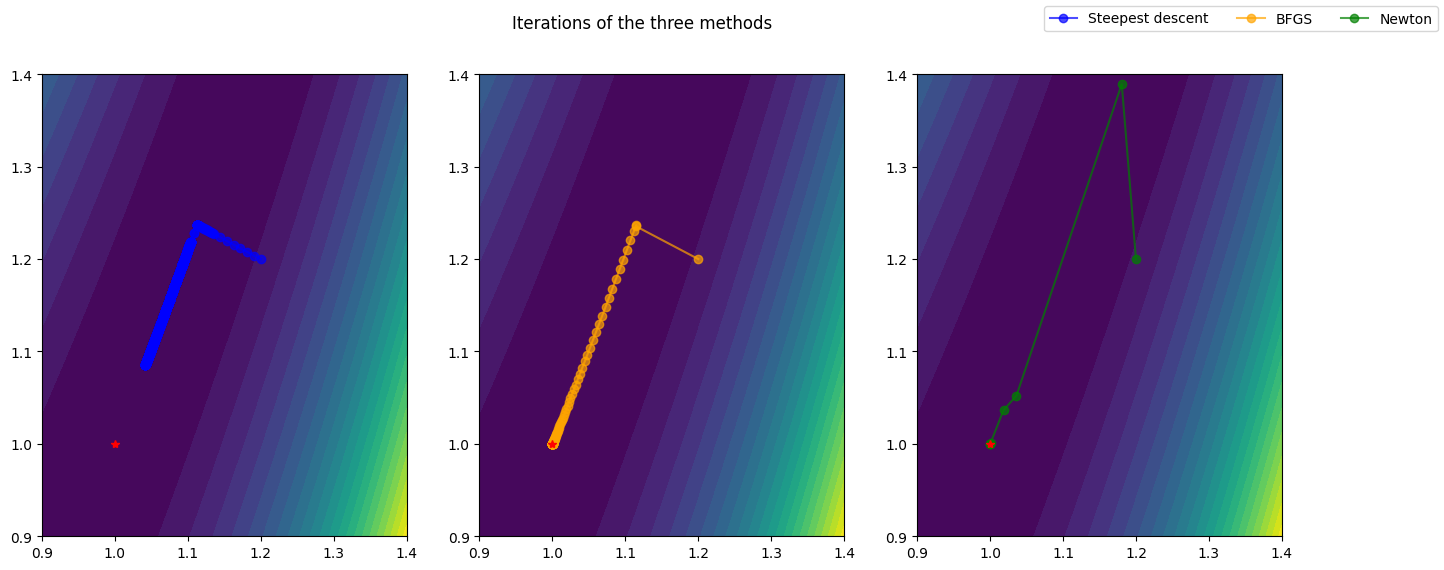

In [334]:

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,6))
create_contour_sympy(expr, (x,y), (0.9,1.4), (0.9,1.4), axs=ax1, lvls=25)
create_contour_sympy(expr, (x,y), (0.9,1.4), (0.9,1.4), axs=ax2, lvls=25)
create_contour_sympy(expr, (x,y), (0.9,1.4), (0.9,1.4), axs=ax3, lvls=25)
ax1.plot([i[0] for i in SD_statses5["xk"]], [i[1] for i in SD_statses5["xk"]], 'o-', alpha=0.7, c="blue", label="Steepest descent")
ax2.plot([i[0] for i in xbfg], [i[1] for i in xbfg], 'o-', alpha=0.7, c="orange", label="BFGS")
ax3.plot([i[0] for i in xs], [i[1] for i in xs], 'o-', alpha=0.7, c="green", label="Newton")
# place the legend next to the suptitle
fig.legend(["Steepest descent", "BFGS", "Newton"], loc="upper right", ncol=3)
ax1.plot(1,1, 'r*')
ax2.plot(1,1, 'r*')
ax3.plot(1,1, 'r*')
fig.suptitle("Iterations of the three methods")